In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx
from scipy.integrate import solve_ivp
import time
import copy

from netdyn import *

In [27]:
def construct_surrogate_matrix(X, t_stable=None):
    """
    Construct surrogate coupling matrix M from time-series data X(t).
    (Implements Eq. E1 in PNAS 2022 Appendix E)
    
    Parameters
    ----------
    X : ndarray (T×N)
        Time-series matrix of node states.
    t_stable : int
        Index (time step) after which the system becomes stable.
        Only data before this index is used for training.
        If None, use first 80% of data by default.
        
    Returns
    -------
    M : ndarray (N×N)
        Surrogate coupling matrix.
    """
    T, N = X.shape
    if t_stable is None:
        t_stable = int(T * 0.8)  # 默认使用前80%
    
    # 构造 (X_t, X_t+1) 训练数据对
    X_t = X[:t_stable - 1]
    X_tp1 = X[1:t_stable]
    
    # 去中心化（可选，提高稳定性）
    X_t_mean = X_t.mean(axis=0, keepdims=True)
    X_t -= X_t_mean
    X_tp1 -= X_t_mean
    
    # 计算 surrogate 矩阵
    X_pinv = np.linalg.pinv(X_t)
    M = X_tp1.T @ X_pinv
    return M

In [28]:
def predict_dynamics_surrogate(M, x0, T_pred):
    """
    Predict future dynamics using surrogate matrix M.
    
    Parameters
    ----------
    M : ndarray (N×N)
        Surrogate coupling matrix.
    x0 : ndarray (N,)
        Initial state at prediction start (last non-stable step).
    T_pred : int
        Prediction horizon (number of steps).
        
    Returns
    -------
    X_pred : ndarray (T_pred×N)
        Predicted trajectory.
    """
    N = len(x0)
    X_pred = np.zeros((T_pred, N))
    x = x0.copy()
    for t in range(T_pred):
        x = M @ x
        X_pred[t] = x
    return X_pred

In [29]:
def compute_rmse(X_true, X_pred):
    """
    Compute RMSE between predicted and true trajectories.
    """
    min_len = min(len(X_true), len(X_pred))
    err = X_true[:min_len] - X_pred[:min_len]
    return np.sqrt(np.mean(err**2))

In [44]:
# =============================================================
# 1. 生成网络
# =============================================================
def generate_network(N=100, kind='ER', avg_k=10, seed=42):
    """
    Generate a network adjacency matrix.
    Matches PNAS 2022 setup (ER / WS / BA, N=100, avg degree ≈ 10)
    """
    np.random.seed(seed)
    if kind == 'ER':
        p = avg_k / (N - 1)
        G = nx.erdos_renyi_graph(N, p, seed=seed)
    elif kind == 'WS':
        G = nx.watts_strogatz_graph(N, k=avg_k, p=0.1, seed=seed)
    elif kind == 'BA':
        m = avg_k // 2
        G = nx.barabasi_albert_graph(N, m, seed=seed)
    else:
        raise ValueError("kind must be one of ['ER','WS','BA']")
    
    # 加权邻接矩阵（文中为随机正权）
    A = nx.to_numpy_array(G)
    weights = np.random.uniform(0.5, 1.5, size=A.shape)
    A = A * weights
    # 归一化
    A /= np.max(A)
    return A

In [46]:
# =============================================================
# 2. 运行真实动力学（SIS模型）
# =============================================================
def run_true_dynamics(A, beta=0.5, gamma=0.2, dt=0.1, T_total=200, seed=42):
    """
    Simulate SIS dynamics on given network (as in PNAS 2022)
    """
    X = sis_dynamics(A, beta=beta, gamma=gamma, dt=dt, T_steps=T_total, seed=seed)
    return X

In [48]:
# =============================================================
# 3. 构造 surrogate matrix (Appendix E)
# =============================================================
def construct_surrogate_matrix(X, t_stable=None):
    """
    Build surrogate matrix from transient dynamics (PNAS 2022 Eq.E1)
    """
    T, N = X.shape
    if t_stable is None:
        t_stable = int(T * 0.75)  # 前75%时间用作训练
    
    X_t = X[:t_stable - 1]
    X_tp1 = X[1:t_stable]
    
    # 去中心化（提升数值稳定性）
    mean_X = X_t.mean(axis=0, keepdims=True)
    X_t -= mean_X
    X_tp1 -= mean_X
    
    M = X_tp1.T @ np.linalg.pinv(X_t)
    return M, t_stable

In [49]:
# =============================================================
# 4. 用 surrogate 进行动力学预测
# =============================================================
def predict_dynamics_surrogate(M, x0, T_pred):
    """
    Linear surrogate prediction: x_{t+1} = M x_t
    """
    N = len(x0)
    X_pred = np.zeros((T_pred, N))
    x = x0.copy()
    for t in range(T_pred):
        x = M @ x
        X_pred[t] = x
    return X_pred

In [50]:
# =============================================================
# 5. 误差评估指标 (RMSE)
# =============================================================
def compute_rmse(X_true, X_pred):
    min_len = min(len(X_true), len(X_pred))
    err = X_true[:min_len] - X_pred[:min_len]
    return np.sqrt(np.mean(err**2))

In [75]:
seed=42
# Step 1: generate network
A = generate_network(N=100, kind=kind, avg_k=10, seed=seed)
print("Network generated:", kind)

# Step 2: run real dynamics
X_true = run_true_dynamics(A, beta=0.5, gamma=0.2, dt=0.1, T_total=200, seed=seed)
print("Dynamics simulated. Shape:", X_true.shape)

Network generated: ER
Dynamics simulated. Shape: (200, 100)


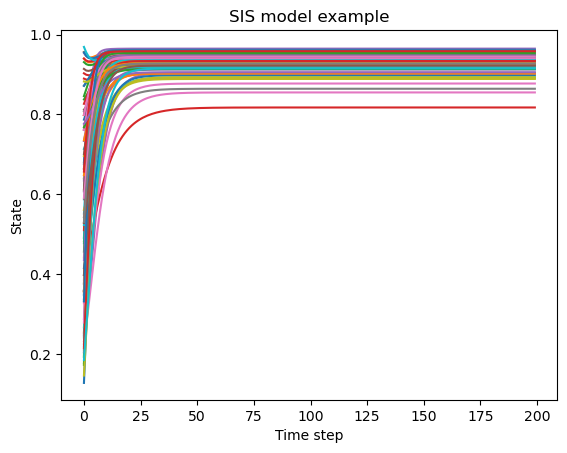

In [76]:
plt.plot(X_true[:, :])
plt.xlabel("Time step")
plt.ylabel("State")
plt.title("SIS model example")
plt.show()

In [51]:
# =============================================================
# 6. 主实验逻辑
# =============================================================
def run_experiment(kind='ER', plot_nodes=3, seed=42):
    """
    Full pipeline replicating PNAS (2022)
    """
    print(f"=== Running experiment on {kind} network ===")



    # Step 3: detect stability region
    diff = np.mean(np.abs(np.diff(X_true, axis=0)), axis=1)
    t_stable = np.argmax(diff < 1e-4) if np.any(diff < 1e-4) else int(0.75 * len(X_true))
    print(f"Estimated non-stable cutoff: t_stable = {t_stable}")

    # Step 4: construct surrogate
    M, _ = construct_surrogate_matrix(X_true, t_stable)
    print("Surrogate matrix constructed. Shape:", M.shape)

    # Step 5: surrogate prediction
    x0 = X_true[t_stable - 1]
    T_pred = len(X_true) - t_stable
    X_pred = predict_dynamics_surrogate(M, x0, T_pred)

    # Step 6: compare to true dynamics
    X_future = X_true[t_stable:]
    rmse = compute_rmse(X_future, X_pred)
    print(f"Prediction RMSE = {rmse:.6f}")

    # Step 7: visualize
    plt.figure(figsize=(7,4))
    plt.plot(X_future[:, :plot_nodes], '--', alpha=0.6, label="True (first nodes)")
    plt.plot(X_pred[:, :plot_nodes], '-', alpha=0.8, label="Predicted")
    plt.xlabel("Time (prediction phase)")
    plt.ylabel("State")
    plt.title(f"{kind} network surrogate prediction (RMSE={rmse:.4f})")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return rmse


# =============================================================
# 7. 执行实验（ER / WS / BA）
# =============================================================
for kind in ['ER', 'WS', 'BA']:
    run_experiment(kind=kind, plot_nodes=5, seed=42)


=== Running experiment on ER network ===
Network generated: ER
Dynamics simulated. Shape: (200, 100)
Estimated non-stable cutoff: t_stable = 29


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 100 is different from 28)